In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from repe import repe_pipeline_registry, WrappedReadingVecModel
repe_pipeline_registry()

from utils import literary_openings_dataset, quotes_dataset, quote_completion_test, historical_year_test, extract_year, eval_completions

In [3]:
# model_name_or_path = "/home/v-hazhong/Models/gpt-neox-20b"
model_name_or_path = "/home/v-hazhong/Models/Llama-2-7b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Reading

In [4]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [18]:
data_dir = "../../data/memorization"
lit_train_data, lit_train_labels, lit_test_data, lit_test_labels = literary_openings_dataset(data_dir)
quote_train_data, quote_train_labels, quote_test_data, quote_test_labels = quotes_dataset(data_dir)

In [22]:
lit_rep_reader = rep_reading_pipeline.get_directions(
    lit_train_data, 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=lit_train_labels, 
    direction_method=direction_method,
)

quote_rep_reader = rep_reading_pipeline.get_directions(
    quote_train_data, 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=quote_train_labels, 
    direction_method=direction_method,
)

In [15]:
from itertools import islice
# Eval validation
results_val = {layer: {} for layer in hidden_layers}
# labels = [[1, 0] for _ in range(98)]
labels = quote_test_labels
H_tests = rep_reading_pipeline(quote_test_data,
                    rep_token=rep_token, 
                    hidden_layers=hidden_layers, 
                    rep_reader=quote_rep_reader,
                    batch_size=8,
                    max_length=2048,
                    padding="longest")

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    unflattened_H_tests = [list(islice(H_test, sum(len(c) for c in labels[:i]), sum(len(c) for c in labels[:i+1]))) for i in range(len(labels))]

    sign = quote_rep_reader.direction_signs[layer]
    eval_func = np.argmin if sign == -1 else np.argmax
    cors = np.mean([labels[i].index(1) == eval_func(H) for i, H in enumerate(unflattened_H_tests)])
    
    results_val[layer] = cors
    
    print(f"{layer} : {cors}")
    print("=====")    

-1 : 0.16326530612244897
=====
-2 : 0.16326530612244897
=====
-3 : 0.8571428571428571
=====
-4 : 0.8571428571428571
=====
-5 : 0.8571428571428571
=====
-6 : 0.8163265306122449
=====
-7 : 0.7959183673469388
=====
-8 : 0.7959183673469388
=====
-9 : 0.8367346938775511
=====
-10 : 0.8571428571428571
=====
-11 : 0.8571428571428571
=====
-12 : 0.8571428571428571
=====
-13 : 0.8571428571428571
=====
-14 : 0.8571428571428571
=====
-15 : 0.8571428571428571
=====
-16 : 0.8775510204081632
=====
-17 : 0.8775510204081632
=====
-18 : 0.8775510204081632
=====
-19 : 0.8775510204081632
=====
-20 : 0.8775510204081632
=====
-21 : 0.8775510204081632
=====
-22 : 0.8775510204081632
=====
-23 : 0.8775510204081632
=====
-24 : 0.8979591836734694
=====
-25 : 0.8775510204081632
=====
-26 : 0.8775510204081632
=====
-27 : 0.8775510204081632
=====
-28 : 0.8775510204081632
=====
-29 : 0.8571428571428571
=====
-30 : 0.8367346938775511
=====
-31 : 0.8571428571428571
=====


In [19]:
from itertools import islice
# Eval validation
results_val = {layer: {} for layer in hidden_layers}
# labels = [[1, 0] for _ in range(98)]
labels = lit_test_labels
H_tests = rep_reading_pipeline(lit_test_data,
                    rep_token=rep_token, 
                    hidden_layers=hidden_layers, 
                    rep_reader=quote_rep_reader,
                    batch_size=8,
                    max_length=2048,
                    padding="longest")

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    unflattened_H_tests = [list(islice(H_test, sum(len(c) for c in labels[:i]), sum(len(c) for c in labels[:i+1]))) for i in range(len(labels))]

    sign = quote_rep_reader.direction_signs[layer]
    eval_func = np.argmin if sign == -1 else np.argmax
    cors = np.mean([labels[i].index(1) == eval_func(H) for i, H in enumerate(unflattened_H_tests)])
    
    results_val[layer] = cors
    
    print(f"{layer} : {cors}")
    print("=====")    

-1 : 0.28125
=====
-2 : 0.3125
=====
-3 : 0.71875
=====
-4 : 0.6875
=====
-5 : 0.6875
=====
-6 : 0.6875
=====
-7 : 0.6875
=====
-8 : 0.6875
=====
-9 : 0.6875
=====
-10 : 0.6875
=====
-11 : 0.71875
=====
-12 : 0.6875
=====
-13 : 0.71875
=====
-14 : 0.71875
=====
-15 : 0.71875
=====
-16 : 0.71875
=====
-17 : 0.71875
=====
-18 : 0.6875
=====
-19 : 0.71875
=====
-20 : 0.71875
=====
-21 : 0.75
=====
-22 : 0.71875
=====
-23 : 0.6875
=====
-24 : 0.71875
=====
-25 : 0.6875
=====
-26 : 0.6875
=====
-27 : 0.78125
=====
-28 : 0.8125
=====
-29 : 0.78125
=====
-30 : 0.8125
=====
-31 : 0.84375
=====


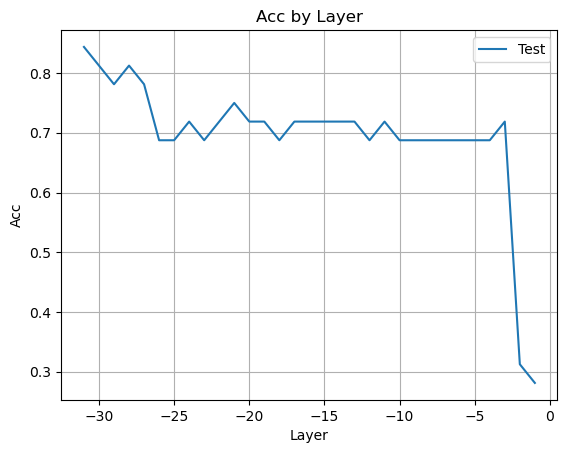

In [20]:
x = list(results_val.keys())
y_val = [results_val[layer] for layer in hidden_layers]
# y_test = [results_test[layer] for layer in hidden_layers]


plt.plot(x, y_val, label="Test")
# plt.plot(x, y_test, label="Test")

plt.title(f"Acc by Layer")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.legend()
plt.grid(True)
plt.show()

## Quote Completions Control

In [12]:
# Early layers work
layer_id = list(range(-28,-32,-1))

block_name="decoder_block"
control_method="reading_vec"
batch_size=64
coeff=2.0 # tune this parameter
max_new_tokens=16

### We do manually instead of rep_control_pipeline here as an example
wrapped_model = WrappedReadingVecModel(model, tokenizer)
wrapped_model.unwrap()
# wrap model at desired layers and blocks
wrapped_model.wrap_block(layer_id, block_name=block_name)
inputs, targets = quote_completion_test(data_dir)

In [13]:
# helper functions
def apply_activations(wrapped_model, 
                      inputs, 
                      activations, 
                      batch_size=8, 
                      use_tqdm=True,
                      **generation_kwargs,
                     ):
    wrapped_model.reset()
    wrapped_model.set_controller(layer_id, activations, masks=1)
    generated = []

    iterator = tqdm(range(0, len(inputs), batch_size)) if use_tqdm else range(0, len(inputs), batch_size)

    for i in iterator:
        inputs_b = inputs[i:i+batch_size]
        decoded_outputs = wrapped_model.generate(inputs_b, **generation_kwargs)
        decoded_outputs = [o.replace(i, "") for o,i in zip(decoded_outputs, inputs_b)]
        generated.extend(decoded_outputs)

    wrapped_model.reset()
    return generated

In [15]:
for t, rep_reader in zip(['literature openings', 'quotes'], [lit_rep_reader, quote_rep_reader]):

    activations = {}
    for layer in layer_id:
        activations[layer] = torch.tensor(0 * coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()

    print("RepReader:", t)
    print("No Control")
    baseline_outputs = apply_activations(wrapped_model,
                                inputs, 
                                activations,
                                batch_size=64,
                                max_new_tokens=max_new_tokens, 
                                use_tqdm=False)
    print(eval_completions(baseline_outputs, targets))

    activations = {}
    for layer in layer_id:
        activations[layer] = torch.tensor(coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()

    print("+ Memorization")
    pos_outputs = apply_activations(wrapped_model,
                                inputs, 
                                activations,
                                batch_size=64,
                                max_new_tokens=max_new_tokens, 
                                use_tqdm=False)
    print(eval_completions(pos_outputs, targets))
    
    activations = {}
    for layer in layer_id:
        activations[layer] = torch.tensor(-coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()
    
    print("- Memorization")
    neg_outputs = apply_activations(wrapped_model,
                                inputs, 
                                activations,
                                batch_size=64,
                                max_new_tokens=max_new_tokens, 
                                use_tqdm=False)
    print(eval_completions(neg_outputs, targets))

RepReader: literature openings
No Control


TypeError: generate() takes 1 positional argument but 2 were given